# Projeto 2 - Estatística

Conforme enunciado no problema 2: Preço vs. Falência, temos as seguintes informações:

1. A cada unidade de tempo (1h) a variável aleatória $p$ é verificada, indicando um novo cliente
2. Existem 2 variáveis de decisão: cliente ($C$) e peixe ($P$)
3. Existem 4 estados vinculados às variáveis de decisão


|Estado|Ação|
|------|------|
|$C \cap P$     |Cozinhar e receber $S$ reais     |
|$C \cap (\sim P)$     |Pescar e conseguir peixe (com probabilidade $q$)     |
|$(\sim C) \cap P$     |Descansar     |
|$(\sim C) \cap (\sim P)$     |Pescar e conseguir peixe (com probabilidade $q$)     |

4. A cada unidade de tempo seu capital é acrescido de $S - 10$ (custo da barraca: 10 reais / hora)

# Algoritmo baseado em contexto

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
class barraca_de_peixe_fresco:
  def __init__(self):
    self.S = 0
    self.Clientes = 0
    self.Peixe = 0
    self.p = 0.4
    self.q = 0.7
    self.Venda_peixe = 32
    self.Preco_barraca = 10
    self.Renda = []
    self.Fluxo_clientes = []

  def pescar(self):
    pegar_peixe = np.random.random()
    if pegar_peixe <= self.q:
      self.Peixe = 1
  
  def cozinhar(self):
    self.vender_peixe()
    self.Peixe = 0
  
  def descansar(self):
    pass

  def pagar_barraca(self):
    self.S -= self.Preco_barraca

  def vender_peixe(self):
    self.S += self.Venda_peixe
    self.Clientes = 0

  def proxima_acao(self):
    probab_novo_cliente = np.random.random()

    if (probab_novo_cliente <= self.p or self.Clientes == 1):
      self.Clientes = 1

      if self.Peixe == 0:
        self.pescar()

      else:
        self.cozinhar()

    else:
      if self.Peixe == 0:
        self.pescar()

      else:
        self.descansar()

    self.pagar_barraca()

    self.Fluxo_clientes.append(self.Clientes)
    self.Renda.append(self.S)

In [70]:
barraca = barraca_de_peixe_fresco()
t = np.arange(1000)
for i in t:
  barraca.proxima_acao()

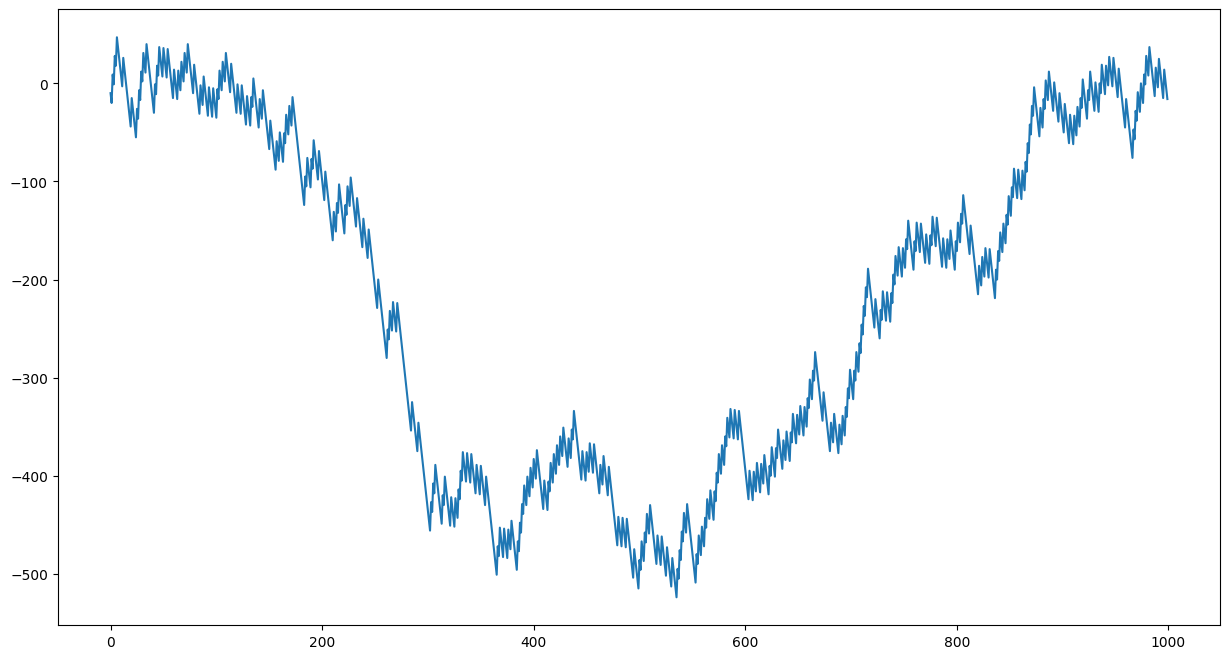

In [71]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(t, barraca.Renda)
plt.show()

# Estratégia com Cadeias de Markov

Sabendo que cada um dos 4 estados mencionados no enunciado podem ser visitados com uma dada probabilidade a depender do estado anterior, 
podemos modelar este problema como uma Cadeia ou Processo de Markov.

Aqui lembramos da hipótese de que, a cada iteração, o pescador deve ter um peixe armazenado e, em seguida, receber um cliente, para vender e receber S reais. 
Isso equivale a dizer que cada cliente espera 1h para receber o pedido. Caso contrário, deixa o estabelecimento.

Assim, nossa cadeia de Markov terá os seguintes estados e transições:

### 1. Estado inicial: $(\sim C) \cap (\sim P)$ (pescando)
- Se $p$ (tem cliente)
    - Se $q$ (tem peixe), próximo estado $C \cap P$
    - Se $\sim q$ (sem peixe), próximo estado $C \cap (\sim P)$


- Se $\sim p$ (sem cliente)
    - Se $q$ (tem peixe), próximo estado $(\sim C) \cap P$
    - Se $\sim q$ (sem peixe), próximo estado $(\sim C) \cap (\sim P)$


### 2. Estado inicial: $C \cap P$ (cozinhando e vai vender)
- Venda: +S 
- Se $p$ (tem cliente), próximo estado $C \cap (\sim P)$
- Se $\sim p$ (sem cliente), próximo estado $(\sim C) \cap (\sim P)$

### 3. Estado inicial: $(\sim C) \cap P$ (descansando)
- Se $p$ (tem cliente)
    - Venda: +S reais: $(\sim C) \cap (\sim P)$
- Se $\sim p$ (sem cliente)
    - Próximo estado $(\sim C) \cap P$

### 4. Estado inicial: $C \cap (\sim P)$ (vai pescar. Perde o cliente que chegou)
- Se $p$ ou $\sim p$, próximo estado $(\sim C) \cap (\sim P)$

Com esta descrição, podemos definir a chamada Matriz de Transição de probabilidades da Cadeia de Markov 


$$
T = 
\left[
  \begin{array}{cccc}
  (1-p)(1-q) & p & 1 & (1-p) \\
  (1-p)q & (1-p) & 0 & 0 \\
  p(1-q) & 0 & 0 & p \\
  pq & 0 & 0 & 0 \\
  \end{array}
\right]  
$$

Onde a ordem das colunas segue, da esquerda para a direita: 

$(\sim C) \cap (\sim P)$, 

$(\sim C) \cap P$, 

$C \cap (\sim P)$, 

$C \cap P$

Que representa a mesma ordem das linhas, do topo para baixo.

Dessa forma, temos que o elemento $T_{i,j}$ tal que $i,j = 0,1,2,3$ representa a probabilidade de transição do estado $i$ para o estado $j$. 
Ou seja, $T_{i,j} = T_{i \to j}$

Em primeiro momento, é importante verificarmos se a matriz corresponde a uma distribuição de probabilidades válida. Como a probabilidade de transição de um estado $i$ deve necessariamente nos levar para um dos estados $j$ possíveis, isso corresponde a

$$
1 = \sum_{j=0}^3 T_{i,j} \\
$$

Ou seja, soma de cada coluna deve resultar em 1. Válido na matriz $T$ que construimos acima

## Estudo de convergência

Sabendo que a multiplicação de duas matrizes $A$ e $B$ é dada pelos elementos obtidos a partir de

$$
(A \times B)_{i,j} = \sum_{k=1}^{N}a_{i,k} b_{k,j}
$$

onde $a_{i,j}$ e ${b_{i,j}}$ são elementos das matrizes $A$ e $B$, respectivamente

Agora sendo a probabilidade $p_{i,j}$ a probabilidade de transição de estado $i \to j$ (que são elementos da matriz $T$), podemos considerar uma variável de tempo $t$ para a qual, a cada instante $t+1$, há uma transição de estados. Dessa forma,

- Sendo que $X_0 = i$ representa nosso estado em $t=0$ é $i$
- Sendo que $X_1 = j$ representa nosso estado em $t=1$ é $j$

Temos que a probabilidade de transição $i \to j$ no passo de um espaço temporal $t \to t+1$ é dado por

$$
p_{i,j} = T(X_1 = j | X_0 = i) = T(X_{t+1} = j | X_{t} = i))
$$

De modo geral, a probabilidade de transição do estado $i \to j$ após $t$ passos temporais é dada por

$$
T(X_{n+t} = j | X_n = i) = (T^t)_{i,j}
$$

Ou seja, $(T^2)_{i,j}$ representa a probabilidade de transição $i \to j$ em 2 passos;

Ou seja, $(T^3)_{i,j}$ representa a probabilidade de transição $i \to j$ em 3 passos;

E assim por diante.

Concluindo: isso quer dizer que, após um número $N$ grande de exponenciações da matriz de transição $T$, temos a probabilidade de $i \to j$ em em todos os passos de tamanho $k = 0,1,2,3,...,N$.

Esse valor, quando convergente, representa a probabilidade média de atingir o estado $j$ no regime estacionário.

### Convergência da matriz de transição

In [19]:
def exponenciar_matrix(matriz_transicao_T, N):
  if N == 0 or N == 1: return matriz_transicao_T
  result = np.matmul(matriz_transicao_T, matriz_transicao_T)
  # print(result, "\n")
  return exponenciar_matrix(result, N-1)

In [25]:
p = 0.4
q = 0.7

T = [
  [(1-p)*(1-q), p, 1, (1-p)], 
  [(1-p)*q, (1-p), 0, 0],
  [(1-q)*p, 0, 0, p], 
  [(p*q), 0, 0, 0]
]
m = exponenciar_matrix(T, 50)
print(m)

[[0.39187294 0.39187294 0.39187294 0.39187294]
 [0.41146659 0.41146659 0.41146659 0.41146659]
 [0.09091452 0.09091452 0.09091452 0.09091452]
 [0.10972442 0.10972442 0.10972442 0.10972442]]


Os resultados acima indicam que, em média, a relação entre estado visitado e probabilidade de sua ocorrência é:


|Estado|Probabilidade|
|------|------|
|$(\sim C) \cap (\sim P)$| 0.39|
|$(\sim C) \cap P$| 0.41|
|$C \cap (\sim P)$| 0.09|
|$C \cap P$| 0.11|